Eigenvectors 
 [[-0.36776971 -0.4607148  -0.31128171 -0.5323537  -0.09304761 -0.49511052
  -0.13564019]
 [-0.36538573 -0.01335292 -0.10287394 -0.13115343 -0.41181689  0.68806117
  -0.44216442]
 [-0.41241169 -0.10670148 -0.08538969 -0.10800763  0.09365532  0.3318173
   0.82504564]
 [-0.43110661  0.41631363 -0.58246887  0.38462973  0.33370827 -0.13469196
  -0.15529619]
 [-0.39020249  0.51429882  0.57211708 -0.41771748  0.23901756 -0.11552612
  -0.10467675]
 [-0.02772751  0.44910744 -0.07846759  0.04241537 -0.78927674 -0.31603016
   0.25834982]
 [-0.47146114 -0.3696763   0.46096003  0.60291432 -0.14672864 -0.19992849
  -0.05977713]]

Eigenvalues 
 [2.40935768 1.49742848 0.30184725 0.38963835 0.91110243 0.79959603
 0.69102978]
7  dimensions retains a variance of  0.9999999999999999
6  dimensions retains a variance of  0.9568789640347986
5  dimensions retains a variance of  0.9012163427455322
4  dimensions retains a variance of  0.8024978027437629
3  dimensions retains a variance of  0.6882

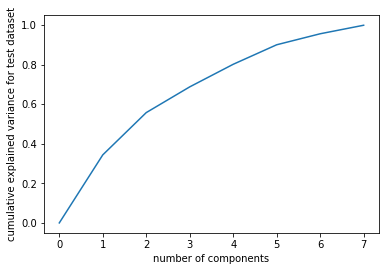

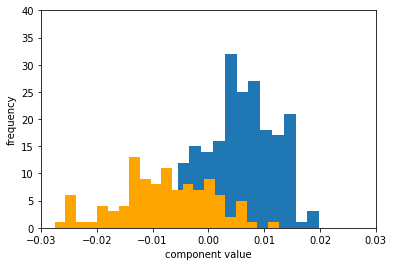

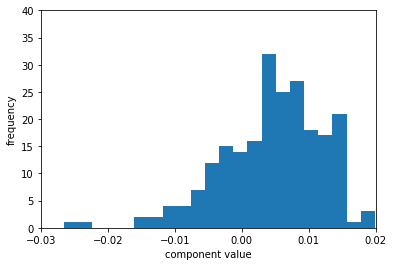

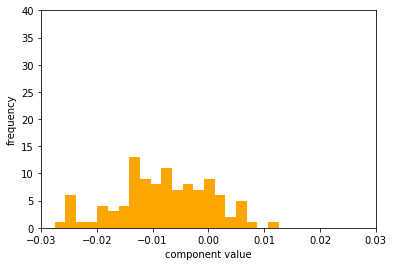

In [90]:
#File is used to normalize, perform PCA and FLD for dimensionality reduction
import sys
import math
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
pi= 3.14159265359

def input_data(filename):
    data = pd.read_csv(filename, sep='\s+', header = 0)
    return data

def normalize(data,mean,sigma): #normalizes the dataset based on information in task 1
    data=(data-mean)/sigma
    return data

def PCA_dimensions(data): #calculates the number of dimensions required to retain different variance amounts
    cov_tr=np.cov(Xn_tr,rowvar=False)#calculates covariance matrix
    eig_val_tr, eig_vec_tr=np.linalg.eig(cov_tr) #calculates eigenvalues and vectors of covariance matrix
    eig_val_tr=np.abs(eig_val_tr)
    print('Eigenvectors \n' ,eig_vec_tr)
    print('\nEigenvalues \n' ,eig_val_tr)

#calculates the error after removing the smallest eigenvalue from the eigenvalues-> loops until no eigenvalues are left
    eig_val_sort=sorted(eig_val_tr)
    dim=7
    var_ret_arr=np.zeros((8,2))
    while len(eig_val_sort)>0:
        var_ret=sum(eig_val_sort)/sum(eig_val_tr)#calculates the retained variance
        var_ret_arr[dim][0]=dim
        var_ret_arr[dim][1]=var_ret
        print(dim, ' dimensions retains a variance of ', var_ret)
        dim=dim-1
        eig_val_sort.remove(min(eig_val_sort))
    return var_ret_arr

def PCA_projection(data):#returns the projection matrix from inputted data
    cov_tr=np.cov(Xn_tr,rowvar=False)#calculates covariance matrix
    eig_val_tr, eig_vec_tr=np.linalg.eig(cov_tr) #calculates eigenvalues and vectors of covariance matrix
    eig_pairs_tr = [((eig_val_tr[i]), eig_vec_tr[:,i]) for i in range(len(eig_val_tr))]# Make a list of eigenvalue, eigenvector tuples
    eig_pairs_tr.sort(reverse=True) #sorts the typles so that the largest eigenvalue is first
    projection_matrix=np.hstack((eig_pairs_tr[0][1].reshape(7,1),#projection matrix only counting the first 5 eigenvalues for 5 dimensions
                            eig_pairs_tr[1][1].reshape(7,1),
                            eig_pairs_tr[2][1].reshape(7,1),
                            eig_pairs_tr[3][1].reshape(7,1),
                            eig_pairs_tr[4][1].reshape(7,1)))
    return projection_matrix
    
def FLD_intraclass(class_0, class_1):
    S_w=(class_0.shape[0]-1)*np.cov(class_0,rowvar=False)+(class_1.shape[0]-1)*np.cov(class_1,rowvar=False)
    return S_w

def FLD_projection(data,W):
    data_t=np.transpose(data)
    W_t=np.transpose(W)
    projected_data=W_t@data_t
    return projected_data

#normalization
X_tr=input_data('pima.tr')
X_te=input_data('pima.te')
X_tr['type']=X_tr['type'].map({'Yes':1, 'No':0}) #maps the new data type
X_te['type']=X_te['type'].map({'Yes':1, 'No':0})
X_tr.drop(X_tr.index[0],inplace=True) #drops the first row
X_te.drop(X_te.index[0],inplace=True) 
X_class_tr=X_tr['type']#saves the type column
X_class_te=X_te['type']
X_tr.drop(['type'],axis=1,inplace=True) #drops the type column 
X_te.drop(['type'],axis=1,inplace=True)
X_mean=X_tr.mean()
X_sigma=X_tr.std()
Xn_tr=normalize(X_tr, X_mean, X_sigma)#normalizes using the training data set and drops the class labels
Xn_te=normalize(X_te, X_mean, X_sigma)

#PCA
dim_tr=PCA_dimensions(Xn_tr) # returns an array containing the retained variance for number of dimensions
plt.figure()
plt.plot(dim_tr[:,1])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance for test dataset');
plt.savefig('cum_var.png')

projection_matrix=PCA_projection(Xn_tr)#projection matrix is defined by tr and then used on te
pX_tr=Xn_tr.dot(projection_matrix)
pX_te=Xn_te.dot(projection_matrix)

#pca=PCA(5) 
#pX_tr=pca.fit_transform(Xn_tr)#performs PCA 7->5 dimensions
#pX_te=pca.fit_transform(Xn_te)

#pX_tr = pd.DataFrame(pX_tr)#converts from np array to pandas df
#pX_te = pd.DataFrame(pX_te) 
pX_tr=pd.concat([pX_tr,X_class_tr],axis=1)#read the classes back in
pX_te=pd.concat([pX_te,X_class_te],axis=1)
pX_tr.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/pX.tr',index=False)
pX_te.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/pX.te',index=False)

#FLD
fX_tr=pd.concat([Xn_tr,X_class_tr],axis=1)#read the classes as we need them for FLD
fX_te=pd.concat([Xn_te,X_class_te],axis=1)
fX_tr_c0=fX_tr.loc[fX_tr.type==0]#split into different classes
fX_tr_c1=fX_tr.loc[fX_tr.type==1]
fX_tr_c0.drop(['type'],axis=1,inplace=True) #drops the type column 
fX_tr_c1.drop(['type'],axis=1,inplace=True) 
fX_te_c0=fX_te.loc[fX_te.type==0]#split into different classes
fX_te_c1=fX_te.loc[fX_te.type==1]
fX_te_c0.drop(['type'],axis=1,inplace=True) #drops the type column 
fX_te_c1.drop(['type'],axis=1,inplace=True) 

#calculates the W matrix required for projection from the training data
mean=fX_tr_c0.mean()-fX_tr_c1.mean()
W=np.linalg.inv(FLD_intraclass(fX_tr_c0,fX_tr_c1))@mean
#projects the new datasets for each class
fX_tr_c0=FLD_projection(fX_tr_c0,W)
fX_tr_c1=FLD_projection(fX_tr_c1,W)
fX_te_c0=FLD_projection(fX_te_c0,W)
fX_te_c1=FLD_projection(fX_te_c1,W)
plt.figure()
plt.hist(fX_te_c0,bins=25)
plt.xlabel('component value')
plt.ylabel('frequency');
plt.xlim([-.030,.030])
plt.ylim([0,40])
plt.hist(fX_te_c1,bins=25,color='orange')
plt.savefig('FLD_freq_combined.png')
plt.figure()
plt.hist(fX_te_c0,bins=25)
plt.xlabel('component value')
plt.ylabel('frequency');
plt.xlim([-.030,.020])
plt.ylim([0,40])
plt.savefig('FLD_freq_c0.png')
plt.figure()
plt.hist(fX_te_c1,bins=25,color='orange')
plt.xlabel('component value')
plt.ylabel('frequency');
plt.xlim([-.030,.030])
plt.ylim([0,40])
plt.savefig('FLD_freq_c1.png')

fX_tr_c0 = pd.DataFrame(fX_tr_c0) 
fX_tr_c0.insert( 1,"type", 0) 
fX_tr_c1 = pd.DataFrame(fX_tr_c1) 
fX_tr_c1.insert( 1,"type", 1) 
fX_te_c0 = pd.DataFrame(fX_te_c0) 
fX_te_c0.insert( 1,"type", 0) 
fX_te_c1 = pd.DataFrame(fX_te_c1) 
fX_te_c1.insert( 1,"type", 1)


fX_tr=pd.concat([fX_tr_c0,fX_tr_c1],axis=0)
fX_te=pd.concat([fX_te_c0,fX_te_c1],axis=0)
fX_tr.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/fX.tr',index=False)
fX_te.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/fX.te',index=False)


Xn_tr=pd.concat([Xn_tr,X_class_tr],axis=1)#read the classes back in
Xn_te=pd.concat([Xn_te,X_class_te],axis=1)
Xn_tr.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/Xn.tr',index=False)
Xn_te.to_csv(r'/home/across/UTK_PhD/Machine_learning_fall_2019/project_2/Xn.te',index=False)



